In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_w: 62,
                         z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/59)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SFWF_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SHF_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSH_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUX_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUY_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

# 1) Calculate tendency of SST and and SSS from mixing

In [4]:
#from Paige's code: The biharmonic horiz diffusion routine
#https://github.com/ocean-transport/cesm-air-sea/blob/master/biharmonic_tendency.ipynb

# raw grid geometry
work1 = (ds['HTN'].values / # HTN: cell widths on North sides of T cell (cm)
         ds['HUW'].values) # HUW: cell widths on West sides of U cell (cm)
tarea = ds['TAREA'].values # TAREA: area of T cells (cm**2)
tarea_r = np.ma.masked_invalid(tarea**-1).filled(0.) # 1/area of T cells
dtn = work1*tarea_r # coefficient of north point in 5-point stencil
dts = np.roll(work1,-1,axis=0)*tarea_r # coeff of south point in 5-point stencil

work1 = (ds['HTE'].values / # HTE: cell widths on East sides of T cells (cm)
         ds['HUS'].values) # HUS: cell widths on South sides of U cells (cm)
dte = work1*tarea_r # coeff of east point in 5-point stencil
dtw = np.roll(work1,-1,axis=1)*tarea_r # coeff of west point in 5-point stencil

kmt = ds['KMT'].values # KMT: k-index of deepest grid cell on T grid (where k is the depth level)

# boundary conditions
kmt_ = kmt > 1 # k=1 is the surface, so this sets all subsurface levels to True
kmtn = np.roll(kmt_,-1,axis=0)
kmts = np.roll(kmt_,1,axis=0)
kmte = np.roll(kmt_,-1,axis=1)
kmtw = np.roll(kmt_,1,axis=1)
cn = np.where(kmt_ & kmtn, dtn, 0.) # where both kmt_ and kmtn are True, set value equal to dtn, else set to 0 -->
# --> essentially sets up a mask for land/surface points
cs = np.where(kmt_ & kmts, dts, 0.)
ce = np.where(kmt_ & kmte, dte, 0.)
cw = np.where(kmt_ & kmtw, dtw, 0.)

# Find single index where there's a min of squared latitude --> so this is probably the lat of equator
j_eq = np.argmin(ds['ULAT'].values[:,0]**2) # ULAT: array of U-grid latitudes (degrees North)
j_eq.shape

# Area of T cells / area of U cell at the equator, all raised to 1.5 power
# this is because the mixing scheme assumes the grid spacing that is at the equator, so coeffs are 1 at equator and reduce toward the poles
ahf = (tarea / ds['UAREA'].values[j_eq, 0])**1.5 # UAREA: area of U cells (cm**2)
ahf[kmt <= 1] = 0.

def laplacian(T, cn, cs, ce, cw):
    cc = -(cn + cs + ce + cw) # cn,cs,ce,cw are coeffs for laplacian
    return (
        cc * T +
        cn * np.roll(T, -1, axis=-2) +
        cs * np.roll(T, 1, axis=-2) +
        ce * np.roll(T, -1, axis=-1) +
        cw * np.roll(T, 1, axis=-1)          
    )

def biharmonic_tendency(T, ahf, cn, cs, ce, cw):
    ah=-3e17 # horizontal tracer mixing coefficient 
    d2tk = ahf * laplacian(T, cn, cs, ce, cw) # take laplacian of T, multiplying by grid factor due to equator
    return ah * laplacian(d2tk, cn, cs, ce, cw) # take laplacian of laplacian of T

/tmp/ipykernel_2042/320061692.py:37: RuntimeWarning: invalid value encountered in power
  ahf = (tarea / ds['UAREA'].values[j_eq, 0])**1.5 # UAREA: area of U cells (cm**2)


In [5]:
arr = [ahf, cn, cs, ce, cw]
for arr_type in arr:
    if str(type(arr_type)) == "<class 'numpy.ndarray'>":
        print("True")
    else:
        print("not ndarray")


True
True
True
True
True


In [6]:
SST_bih = xr.DataArray(
    dsa.map_blocks(biharmonic_tendency, ds.SST.data, ahf, cn, cs, ce, cw, 
                   dtype=ds.SST.data.dtype),
    dims=ds.SST.dims,
    coords=ds.SST.reset_coords(drop=True).coords
)
SST_bih

<xarray.DataArray 'biharmonic_tendency-08fe864db399e899a080542b4f149197' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [7]:
SSS_bih = xr.DataArray(
    dsa.map_blocks(biharmonic_tendency, ds.SSS.data, ahf, cn, cs, ce, cw, 
                   dtype=ds.SSS.data.dtype),
    dims=ds.SSS.dims,
    coords=ds.SSS.reset_coords(drop=True).coords
)
SSS_bih

<xarray.DataArray 'biharmonic_tendency-1604f9c4df7a4e2347e750f622e7ee27' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

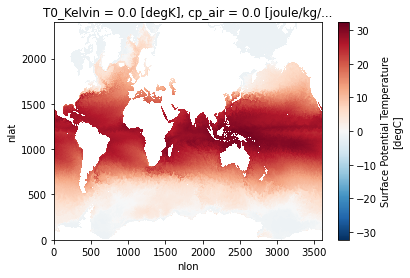

In [8]:
ds.SST[0].plot()

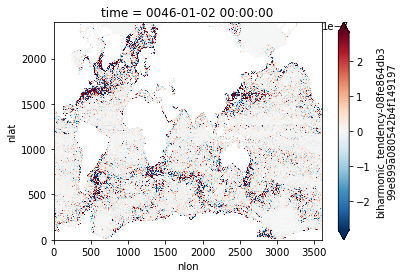

In [9]:
SST_bih[0].plot(robust=True);

# 2) Convert to density tendency

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S)
$$

In [10]:
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_w: 62,
                         z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/59)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SFWF_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SHF_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSH_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUX_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUY_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

In [11]:
#for a single timestep to save computation cost
sst = ds.SST[0]
sss = ds.SSS[0]

In [12]:
#runit2mass = 1.035e3 #rho_0

drhodt = xr.apply_ufunc(jmd95numba.drhodt, sss, sst, 0,
                        output_dtypes=[sst.dtype],
                        dask='parallelized').reset_coords(drop=True).load()
drhods = xr.apply_ufunc(jmd95numba.drhods, sss, sst, 0,
                        output_dtypes=[sss.dtype],
                        dask='parallelized').reset_coords(drop=True).load()

#alpha = - drhodt / runit2mass
#beta = drhods / runit2mass

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in drhodt
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in drhods
  return func(*(_execute_task(a, cache) for a in args))


In [13]:
SST_bih

<xarray.DataArray 'biharmonic_tendency-08fe864db399e899a080542b4f149197' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [14]:
dens_tend = drhodt * SST_bih[0] + drhods * SSS_bih[0]
dens_tend

<xarray.DataArray (nlat: 2400, nlon: 3600)>
dask.array<add, shape=(2400, 3600), dtype=float64, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates:
    time     object 0046-01-02 00:00:00
Dimensions without coordinates: nlat, nlon

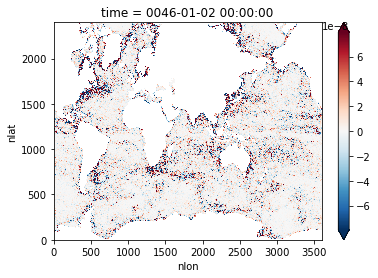

In [15]:
dens_tend.plot(robust=True);

# 3) Decompose into the following form

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) = M(\rho) + C
$$

You can calculate $C$ as

$$
C = \frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) - M(\rho)
$$

In [16]:
rho = xr.apply_ufunc(jmd95numba.rho, ds.SSS, ds.SST, 0,
                        output_dtypes=[ds.SST.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load())

In [17]:
rho

<xarray.DataArray (time: 14965, nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [18]:
rho_bih = xr.DataArray(dsa.map_blocks(biharmonic_tendency, rho.data, ahf, cn, cs, ce, cw, 
                                      dtype=rho.data.dtype),
                       dims=rho.dims,
                       coords=rho.reset_coords(drop=True).coords)

rho_bih

<xarray.DataArray 'biharmonic_tendency-802a090dae475f420230e50815d3cc34' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


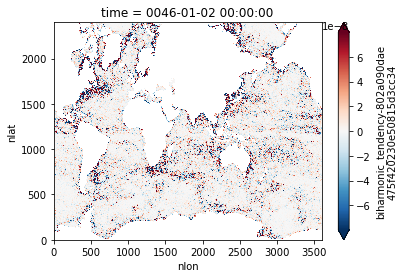

In [19]:
rho_bih[0].plot(robust=True);

In [20]:
cabbeling = dens_tend - rho_bih

In [21]:
cabbeling

<xarray.DataArray (nlat: 2400, nlon: 3600, time: 14965)>
dask.array<sub, shape=(2400, 3600, 14965), dtype=float64, chunksize=(2400, 3600, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


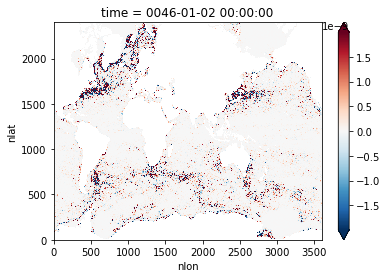

In [22]:
cabbeling.isel(time=0).plot(robust=True);

In [23]:
selection = dict(time=0, nlat=slice(1400,1700), nlon=slice(300,500))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


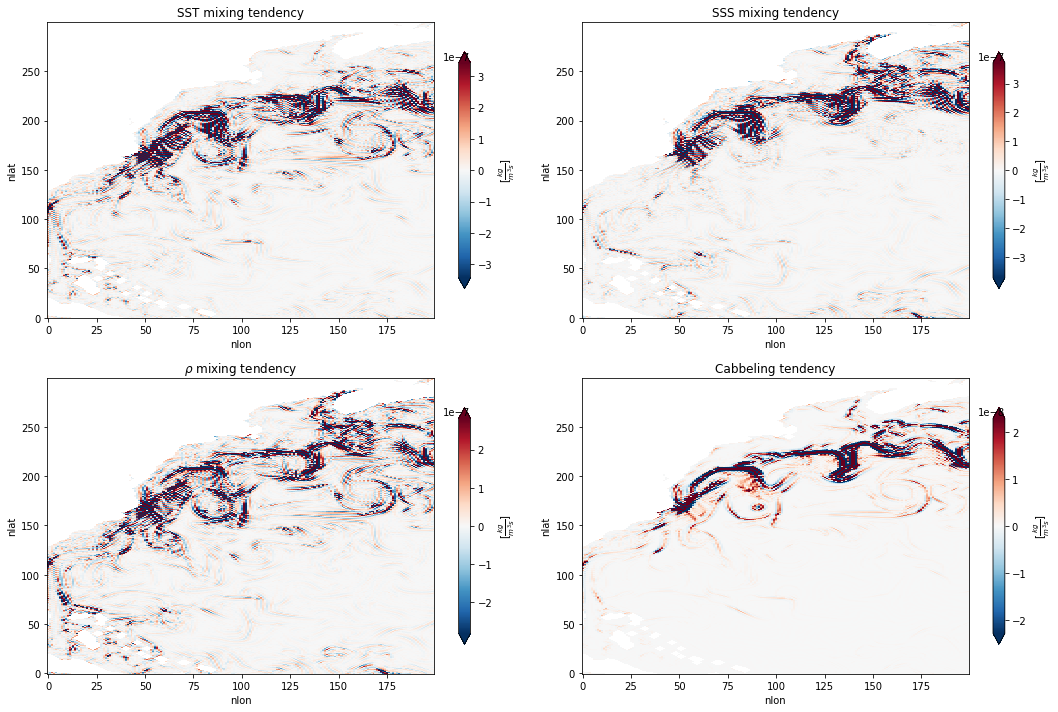

In [24]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

(SST_bih*drhodt).isel(**selection).plot(robust=True, ax=ax[0,0], 
                                 cbar_kwargs=kwargs)
ax[0,0].set_title('SST mixing tendency')
(SSS_bih*drhods).isel(**selection).plot(robust=True, ax=ax[0,1], 
                                 cbar_kwargs=kwargs)
ax[0,1].set_title('SSS mixing tendency')
(rho_bih).isel(**selection).plot(robust=True, ax=ax[1,0], 
                                 cbar_kwargs=kwargs)
ax[1,0].set_title(r'$\rho$ mixing tendency')
(cabbeling).isel(**selection).plot(robust=True, ax=ax[1,1], 
                                   cbar_kwargs=kwargs)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

## Create contours to overlay on above figs

In [25]:
rho

<xarray.DataArray (time: 14965, nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

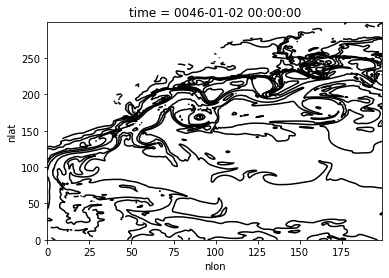

In [26]:
rho.isel(**selection).plot.contour(levels=np.arange(1021, 1027, 0.5), colors='k')

In [27]:
def plot_contours_tend_terms(axis, tend_term):
    """Plot surface density contours and tendency terms"""
    c = rho.isel(**selection).plot.contour(levels=np.arange(1021, 1027), colors='grey', linestyles='dashed', ax=axis)
    plt.clabel(c)
    tend_term.isel(**selection).plot(robust=True, ax=axis,
                                     cbar_kwargs=kwargs)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


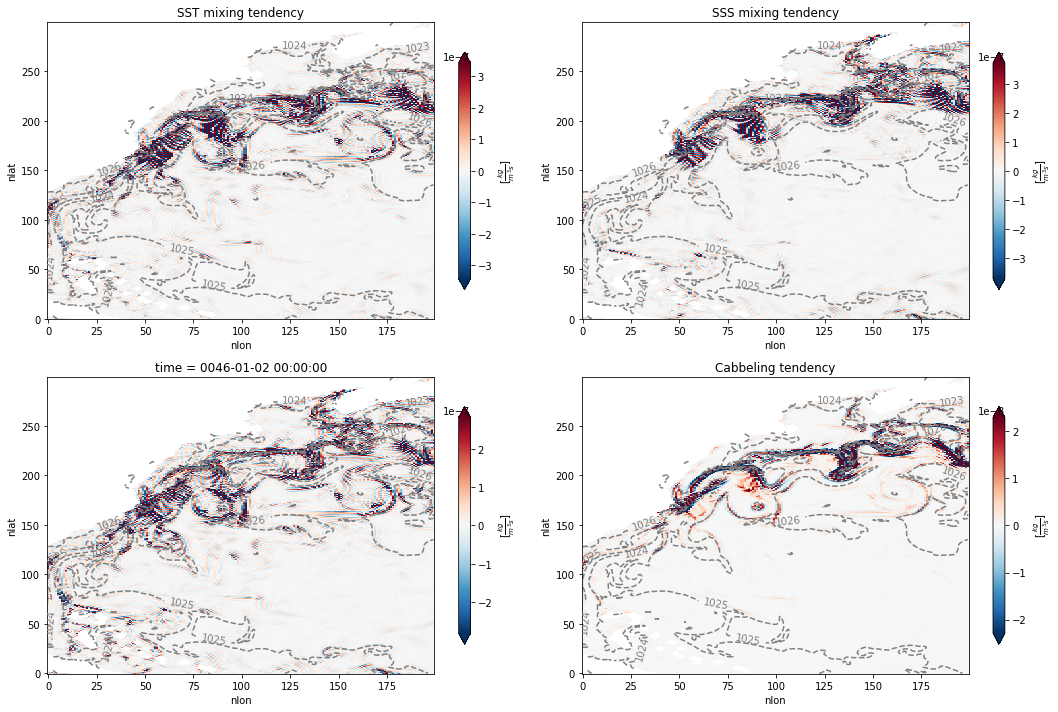

In [28]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

plot_contours_tend_terms(ax[0,0], SST_bih*drhodt)
ax[0,0].set_title('SST mixing tendency')

plot_contours_tend_terms(ax[0,1], SSS_bih*drhods)
ax[0,1].set_title('SSS mixing tendency')

plot_contours_tend_terms(ax[1,0], rho_bih)
ax[1,1].set_title(r'$\rho$ mixing tendency')

plot_contours_tend_terms(ax[1,1], cabbeling)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

# 4) Make histogram of each term
(use logarithmic scale on y-axis)

## But first figure out masking in order to compute volume

In [29]:
ds.REGION_MASK

<xarray.DataArray 'REGION_MASK' (nlat: 2400, nlon: 3600)>
dask.array<open_dataset-5b10252e2fd008145fbc7138ea6d96b7REGION_MASK, shape=(2400, 3600), dtype=float64, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates: (12/51)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    salt_to_ppt         float64 ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
    vonkar              float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  basin index number (signed integers)

In [30]:
grid_name = 'POP_gx1v7'

grid = pop_tools.get_grid(grid_name)
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [31]:
regions = np.unique(ds.REGION_MASK)
regions

array([-14., -13.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.])

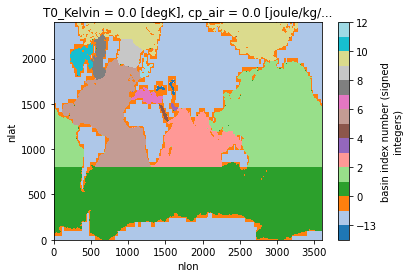

In [32]:
ds.REGION_MASK.plot.contourf(levels=regions, cmap='tab20');

In [33]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')
mask3d

<xarray.DataArray (region: 13, nlat: 384, nlon: 320)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
Dimensions without coordinates: nlat, nlon
Attributes:
    mask_name:  default

In [34]:
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

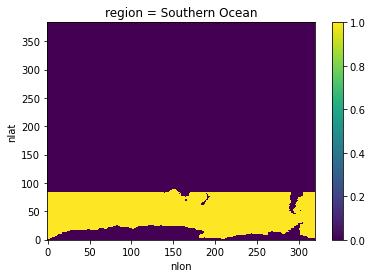

In [35]:
mask3d.sel(region='Southern Ocean').plot()

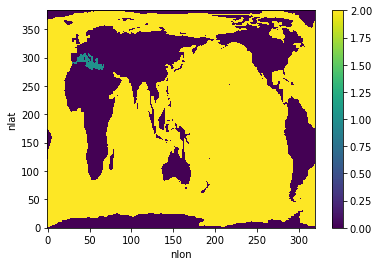

In [36]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='lat-range-basin')
mask3d.sum('region').plot();

### Define Volume

In [37]:
ds.dz * ds.DXT * ds.DYT

<xarray.DataArray (z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<mul, shape=(62, 2400, 3600), dtype=float64, chunksize=(62, 2400, 3600), chunktype=numpy.ndarray>
Coordinates: (12/53)
    T0_Kelvin           float64 0.0
    cp_air              float64 0.0
    cp_sw               float64 0.0
    days_in_norm_year   timedelta64[ns] 00:00:00
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    fwflux_factor       float64 0.0
    ...                  ...
    TAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

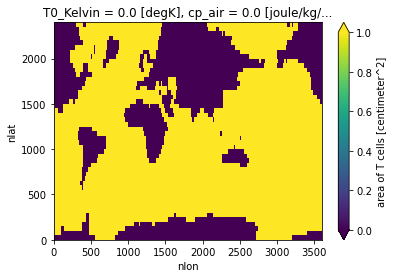

In [38]:
ds.TAREA.plot(vmin=0, vmax=1)

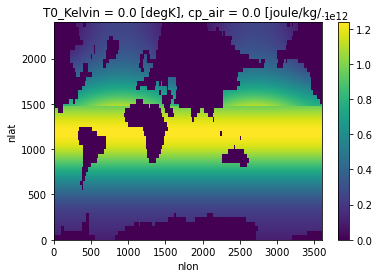

In [39]:
(ds.DXT * ds.DYT).plot()

In [40]:
diff = ds.TAREA - (ds.DXT * ds.DYT)

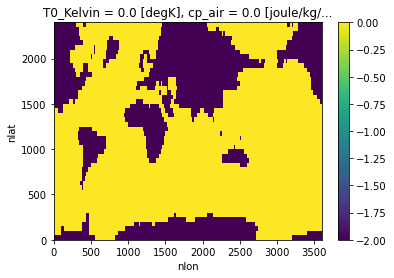

In [41]:
diff.plot()

(-0.001, 0.001)

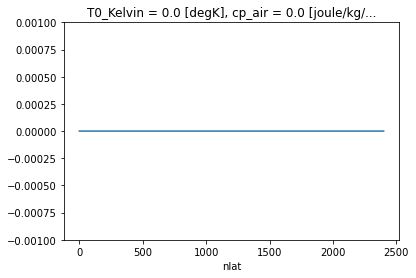

In [42]:
diff.all(dim='nlon').plot()
plt.ylim(-0.001, 0.001)

(-0.001, 0.001)

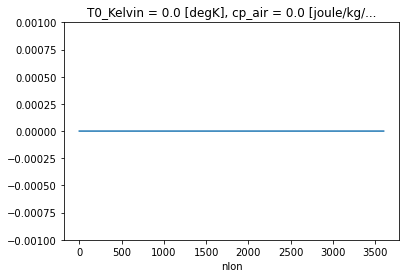

In [43]:
diff.all(dim='nlat').plot()
plt.ylim(-0.001, 0.001)

In [44]:
ds.dz

<xarray.DataArray 'dz' (z_t: 62)>
dask.array<open_dataset-5b10252e2fd008145fbc7138ea6d96b7dz, shape=(62,), dtype=float32, chunksize=(62,), chunktype=numpy.ndarray>
Coordinates: (12/32)
    T0_Kelvin           float64 ...
    cp_air              float64 ...
    cp_sw               float64 ...
    days_in_norm_year   timedelta64[ns] ...
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    fwflux_factor       float64 ...
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
Attributes:
    long_name:  thickness of layer k
    units:      centimeters

In [45]:
ds.TAREA * ds.dz

<xarray.DataArray (nlat: 2400, nlon: 3600, z_t: 62)>
dask.array<mul, shape=(2400, 3600, 62), dtype=float64, chunksize=(2400, 3600, 62), chunktype=numpy.ndarray>
Coordinates: (12/53)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
Dimensions without coordinates: nlat, nlon

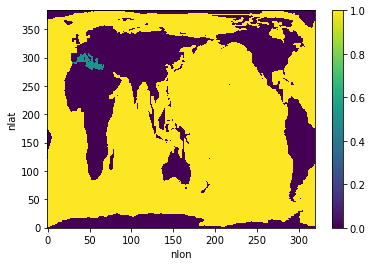

In [46]:
(mask3d.sum('region')/2).plot()

In [47]:
hfacc = (mask3d.sum('region')/2).to_dataset(name='hfacc')

In [48]:
#mask is 6.25 x 11.25 times coarser than ds, need to interp?
hfacc

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    hfacc    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [49]:
a = xr.DataArray([1, 2, 3], dims="x")
b = xr.DataArray([5, 6], dims="y")

In [50]:
a

<xarray.DataArray (x: 3)>
array([1, 2, 3])
Dimensions without coordinates: x

In [51]:
b

<xarray.DataArray (y: 2)>
array([5, 6])
Dimensions without coordinates: y

In [52]:
a2, b2 = xr.broadcast(a, b)

In [53]:
a2

<xarray.DataArray (x: 3, y: 2)>
array([[1, 1],
       [2, 2],
       [3, 3]])
Dimensions without coordinates: x, y

In [54]:
ds_test = xr.Dataset({"a": a, "b": b})
(ds2,) = xr.broadcast(ds_test)  # use tuple unpacking to extract one dataset
ds2

<xarray.Dataset>
Dimensions:  (x: 3, y: 2)
Dimensions without coordinates: x, y
Data variables:
    a        (x, y) int64 1 1 2 2 3 3
    b        (x, y) int64 5 6 5 6 5 6

In [55]:
ds_test

<xarray.Dataset>
Dimensions:  (x: 3, y: 2)
Dimensions without coordinates: x, y
Data variables:
    a        (x) int64 1 2 3
    b        (y) int64 5 6

In [143]:
hfacc_br, tarea_br = xr.broadcast(hfacc, ds.TAREA)

ValueError: arguments without labels along dimension 'nlat' cannot be aligned because they have different dimension sizes: {384, 2400}

In [140]:
ds.TAREA * hfacc

ValueError: arguments without labels along dimension 'nlat' cannot be aligned because they have different dimension sizes: {384, 2400}

In [56]:
vol = ds.TAREA * ds.dz

In [57]:
vol

<xarray.DataArray (nlat: 2400, nlon: 3600, z_t: 62)>
dask.array<mul, shape=(2400, 3600, 62), dtype=float64, chunksize=(2400, 3600, 62), chunktype=numpy.ndarray>
Coordinates: (12/53)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
Dimensions without coordinates: nlat, nlon

## Now, Histograms

In [58]:
from xhistogram.xarray import histogram

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


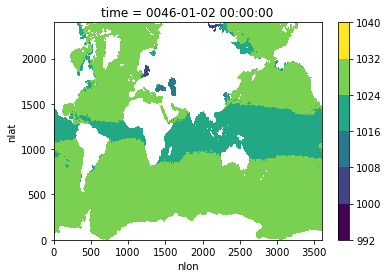

In [59]:
rho[0].plot.contourf()

In [1]:
delta_rho = 0.01
rho_bins = np.arange(1015, 1035, delta_rho)

NameError: name 'np' is not defined

In [2]:
rho_bins.size

NameError: name 'rho_bins' is not defined

In [62]:
density_dist = histogram(rho.rename('rho0'), bins=[rho_bins],
                         weights=vol, dim=['nlon', 'nlat', 'z_t'])

In [62]:
density_dist = histogram(rho.rename('rho0'), bins=[rho_bins],
                         weights=vol, dim=['nlon', 'nlat', 'z_t'])

In [63]:
density_dist

<xarray.DataArray 'histogram_rho0' (time: 14965, rho0_bin: 2199)>
dask.array<sum-aggregate, shape=(14965, 2199), dtype=float64, chunksize=(1, 2199), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
  * rho0_bin  (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.037e+03 1.037e+03

In [ ]:
plt.figure(figsize=(12,5))
density_dist[0].plot(label='first timestep')
density_dist[-1].plot(label='last timestep')
plt.legend()
#plt.xlim(1036.5, 1037.3)
plt.grid();

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


## Transformation

In [ ]:
tendency_terms = xr.merge([(SST_bih*drhodt).rename('sst'), (SSS_bih*drhods).rename('sss'),
                           rho_bih.rename('rho'), cabbeling.rename('cabbeling')])

In [ ]:
all_tendencies = list(tendency_terms)

In [ ]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=variable.fillna(0.), dim=['nlon', 'nlat', 'z_t'])
    return hist / (-delta_sigma)

In [ ]:
all_dsets_th = xr.merge([histogram_func(tendency_terms[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])